# Modelling

## Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

In [3]:
def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

In [4]:
def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

In [5]:
def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [6]:
df = pd.read_csv('data/tab_df.csv')
#df = df[['diff', 'avg_gain', 'avg_loss', 'rs', 'rsi', 'slope', 'target']]
df.head(5)

,tick,diff,gain,loss,avg_gain,avg_loss,rs,rsi,ssma,lsma,sma_diff,sema,lema,ema_diff,slope,sma_slope,target
0,1.14541,0.00009,0.00009,0.00000,0.000038,0.000060,0.633333,38.775510,1.145300,1.146044,-0.000744,1.145337,1.145868,-0.000531,-52.366769,-74.080770,same
1,1.14547,0.00006,0.00006,0.00000,0.000044,0.000048,0.916667,47.826087,1.145296,1.146039,-0.000743,1.145361,1.145859,-0.000498,45.855097,-73.563328,same
2,1.14541,-0.00006,0.00000,0.00006,0.000044,0.000045,0.977778,49.438202,1.145295,1.146032,-0.000737,1.145370,1.145849,-0.000479,68.029719,-71.767752,same
3,1.14533,-0.00008,0.00000,0.00008,0.000044,0.000038,1.157895,53.658537,1.145301,1.146019,-0.000718,1.145363,1.145837,-0.000474,68.222514,-68.346113,same
4,1.14526,-0.00007,0.00000,0.00007,0.000036,0.000045,0.800000,44.444444,1.145292,1.146011,-0.000719,1.145344,1.145824,-0.000480,69.007147,-62.391360,same


In [7]:
target_col = 'target'

print(f'Record count : {len(df)}')
print('--------------------------')
print(df[target_col].value_counts())
print('--------------------------')
print(df[target_col].value_counts(normalize=True))

Record count : 186166
--------------------------
same        180369
decrease      2992
increase      2805
Name: target, dtype: int64
--------------------------
same        0.968861
decrease    0.016072
increase    0.015067
Name: target, dtype: float64


In [8]:
print('Data split')
df_tot, df1, df2 = split_data(df, 5)
print('----------------------------------------------------')
print('Scale encode train valid data')
x_scaled, y_encoded, y_map = data_prep(df1, apply_smote = False)
print('----------------------------------------------------')
print('Scale encode test data')
x_scaled1, y_encoded1, y_map1 = data_prep(df2, apply_smote = False)

Data split
df_tot count : 186166
df1 count : 148933
df2 count : 37233
----------------------------------------------------
Scale encode train valid data
Record count : 148933
--------------------------
same        144847
decrease      2062
increase      2024
Name: target, dtype: int64
--------------------------
same        0.972565
decrease    0.013845
increase    0.013590
Name: target, dtype: float64
----------------------------------------------------
Scale encode test data
Record count : 37233
--------------------------
same        35522
decrease      930
increase      781
Name: target, dtype: int64
--------------------------
same        0.954046
decrease    0.024978
increase    0.020976
Name: target, dtype: float64


## Train test split

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Neural Network

### Network building

In [10]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    Dense(units = 3, activation='softmax')
])

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 915
Trainable params: 915
Non-trainable params: 0
_________________________________________________________________


### Parameters

In [13]:
epoch_val         = 10
batch_size_val    = 64

verbose_val       = 2
workers_val       = -1

### Training

In [14]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
1862/1862 - 9s - loss: 0.1095 - accuracy: 0.9666 - val_loss: 0.0504 - val_accuracy: 0.9830
Epoch 2/10
1862/1862 - 9s - loss: 0.0488 - accuracy: 0.9831 - val_loss: 0.0466 - val_accuracy: 0.9838
Epoch 3/10
1862/1862 - 9s - loss: 0.0468 - accuracy: 0.9833 - val_loss: 0.0449 - val_accuracy: 0.9834
Epoch 4/10
1862/1862 - 9s - loss: 0.0460 - accuracy: 0.9835 - val_loss: 0.0447 - val_accuracy: 0.9843
Epoch 5/10
1862/1862 - 9s - loss: 0.0453 - accuracy: 0.9835 - val_loss: 0.0453 - val_accuracy: 0.9844
Epoch 6/10
1862/1862 - 9s - loss: 0.0452 - accuracy: 0.9835 - val_loss: 0.0440 - val_accuracy: 0.9844
Epoch 7/10
1862/1862 - 9s - loss: 0.0450 - accuracy: 0.9836 - val_loss: 0.0446 - val_accuracy: 0.9832
Epoch 8/10
1862/1862 - 9s - loss: 0.0447 - accuracy: 0.9837 - val_loss: 0.0432 - val_accuracy: 0.9843
Epoch 9/10
1862/1862 - 8s - loss: 0.0447 - accuracy: 0.9836 - val_loss: 0.0439 - val_accuracy: 0.9844
Epoch 10/10
1862/1862 - 9s - loss: 0.0443 - accuracy: 0.9840 - val_loss: 0.0431 - 

### DNN Validation

In [15]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.78      0.64      0.70       431
    increase       0.75      0.58      0.65       397
        same       0.99      0.99      0.99     28959

    accuracy                           0.98     29787
   macro avg       0.84      0.74      0.78     29787
weighted avg       0.98      0.98      0.98     29787



### DNN Prediction

In [16]:
predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

              precision    recall  f1-score   support

    decrease       0.84      0.48      0.61       930
    increase       0.90      0.49      0.63       781
        same       0.98      1.00      0.99     35522

    accuracy                           0.97     37233
   macro avg       0.91      0.65      0.74     37233
weighted avg       0.97      0.97      0.97     37233



## RF Results

In [17]:
%%time
clf = RandomForestClassifier() 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.81      0.65      0.72       431
    increase       0.80      0.64      0.72       397
        same       0.99      1.00      0.99     28959

    accuracy                           0.99     29787
   macro avg       0.87      0.76      0.81     29787
weighted avg       0.98      0.99      0.99     29787

Wall time: 2min 6s


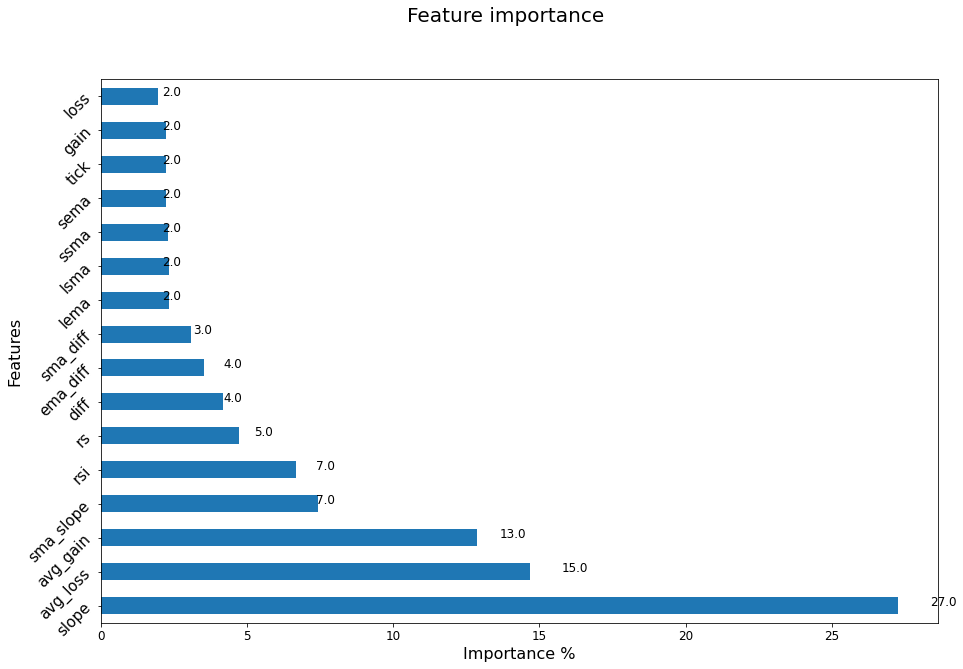

In [18]:
x_cols = df.columns[df.columns != 'target']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(20).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(1.05*value, index, str(value), fontsize=12)